# GLM Example Usage: Auditory Stimulation

We will use a General Linear Model to compare the fMRI signal during periods of auditory stimulation versus periods of rest.

## Workflow

1. **Defining stimulus events:** the **`events.tsv`** file in the dataset defines the timing of the auditory stimulation and rest periods. We create an **`events`** dataframe from the data in the **`events.tsv`** file.

2. **Building the design matrix:** we use the Nilearn **`FirstLevelModel`** class to set the parameters of the design matrix.

3. **Model fitting:** we use the **`fit`** method of the **`FirstLevelModel`** class to build the design matrix and fit the model using the information provided by the **`events`** dataframe.

4. **Statistical inference (Contrasts):** we creat a contrast for `listening > rest`. A T-test allows to see if the difference in Beta weights is statistically significant compared to the noise (residuals).

5. **Results:** the analysis generates a Statistical Parametric Map, highlighting areas if the "listening" regressor significantly outweighs the "rest" regressor.

## Install Nilearn

In [1]:
!pip install -q nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 93.3 MB/s eta 0:00:00


## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Retrieving the Dataset

We use a single-subject auditory fMRI dataset originally provided by SPM (Statistical Parametric Mapping).

In [3]:
from nilearn.datasets import fetch_spm_auditory

# download the auditory dataset
subject_data = fetch_spm_auditory()

[fetch_spm_auditory] Added README.md to /root/nilearn_data

[fetch_spm_auditory] Dataset created in /root/nilearn_data/spm_auditory

[fetch_spm_auditory] Data absent, downloading...

[fetch_spm_auditory] Downloading data from 
https://www.fil.ion.ucl.ac.uk/spm/download/data/MoAEpilot/MoAEpilot.bids.zip ...

[fetch_spm_auditory] Downloaded 1384448 of 30176409 bytes (4.6%%,   23.0s remaining)

[fetch_spm_auditory] Downloaded 7356416 of 30176409 bytes (24.4%%,    6.7s remaining)

[fetch_spm_auditory] Downloaded 11083776 of 30176409 bytes (36.7%%,    5.5s remaining)

[fetch_spm_auditory] Downloaded 14319616 of 30176409 bytes (47.5%%,    4.6s remaining)

[fetch_spm_auditory] Downloaded 17383424 of 30176409 bytes (57.6%%,    3.8s remaining)

[fetch_spm_auditory] Downloaded 20611072 of 30176409 bytes (68.3%%,    2.9s remaining)

[fetch_spm_auditory] Downloaded 23920640 of 30176409 bytes (79.3%%,    1.9s remaining)

[fetch_spm_auditory] Downloaded 27303936 of 30176409 bytes (90.5%%,    0.9s remaining)

[fetch_spm_auditory]  ...done. (10 seconds, 0 min)

[fetch_spm_auditory] Extracting data from /root/nilearn_data/spm_auditory/MoAEpilot.bids.zip...

[fetch_spm_auditory] .. done.

## Inspecting the Dataset

Print the path of func image:

In [4]:
subject_data.func[0]

'/root/nilearn_data/spm_auditory/MoAEpilot/sub-01/func/sub-01_task-auditory_bold.nii'

We display the mean functional image and the subject's anatomy:

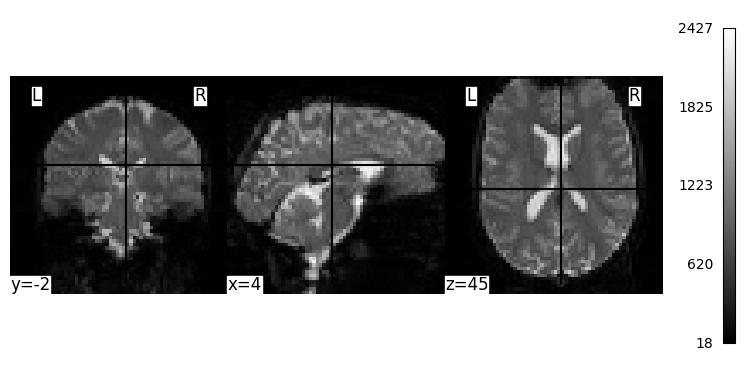

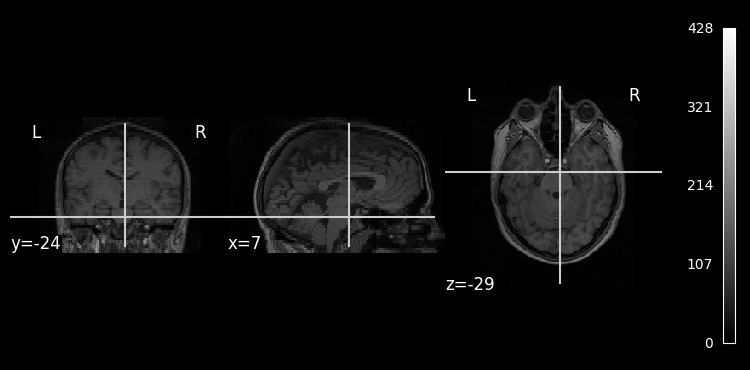

In [5]:
from nilearn.image import mean_img
from nilearn.plotting import plot_anat, plot_img, plot_stat_map

# functional image
fmri_img = subject_data.func

# mean functional image
mean_img = mean_img(subject_data.func[0])

# plot mean functional image
plot_img(mean_img, cbar_tick_format="%i")

# plot anatomical image
plot_anat(subject_data.anat, cbar_tick_format="%i")

## Defining Stimulus Events

The stimulus events are defined in the **`events.tsv`** file in the dataset, which defines the timing of the auditory stimulation and rest periods.

We create an **`events`** dataframe from the data in the **`events.tsv`** file.

In [6]:
# create dataframe of events
events = pd.read_table(subject_data.events)

events

,onset,duration,trial_type
0,42,42,listening
1,126,42,listening
2,210,42,listening
3,294,42,listening
4,378,42,listening
5,462,42,listening
6,546,42,listening


## Performing the GLM Analysis

### Setting Parameters of Design Matrix

We use the Nilearn **`FirstLevelModel`** class to set the parameters of the design matrix.

We set the parameters of the first-level model as follows:

* **`t_r=7`**: is the repetition time in seconds.
* **`noise_model='ar1'`** specifies the noise covariance model: a lag-1 dependence.
* **`standardize=False`** we do not rescale the time series to mean 0, variance 1.
* **`hrf_model='spm'`** we use the SPM canonical HRF model.
* **`drift_model='cosine'`** we model the signal drifts as slow oscillating time functions
* **`high_pass=0.01`** defines the cutoff frequency in Hz.

In [7]:
from nilearn.glm.first_level import FirstLevelModel

# set parameters of design matrix
fmri_glm = FirstLevelModel(
    t_r=subject_data.t_r,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm",
    drift_model="cosine",
    high_pass=0.01,
    verbose=1,
    minimize_memory=False
)


### Fitting the Model

We use the **`fit`** method of the **`FirstLevelModel`** class to build the design matrix and fit the model using the information provided by the **`events`** dataframe.

In [8]:
# fit the GLM model
fmri_glm = fmri_glm.fit(fmri_img, events)

[FirstLevelModel.fit] Loading data from 
'/root/nilearn_data/spm_auditory/MoAEpilot/sub-01/func/sub-01_task-auditory_bold.nii'

[FirstLevelModel.fit] Computing mask

[FirstLevelModel.fit] Resampling mask

[FirstLevelModel.fit] Finished fit

[FirstLevelModel.fit] Computing run 1 out of 1 runs (go take a coffee, a big one).

[FirstLevelModel.fit] Performing mask computation.

[FirstLevelModel.fit] Loading data from <nibabel.nifti1.Nifti1Image object at 0x7ad0b560b950>

[FirstLevelModel.fit] Extracting region signals

[FirstLevelModel.fit] Cleaning extracted signals

[FirstLevelModel.fit] Masking took 1 seconds.

[FirstLevelModel.fit] Performing GLM computation.

[FirstLevelModel.fit] GLM took 4 seconds.

[FirstLevelModel.fit] Computation of 1 runs done in 6 seconds.

### Display the Design Matrix

We display the design matrix: rows represent time, and columns contain the predictors.

We take the first design matrix.

The model is implictily meant to for multiple runs, but in our case the model computes only one run.

In [9]:
# get the design matrix
design_matrix = fmri_glm.design_matrices_[0]

We plot the design matrix:

<Axes: label='conditions', ylabel='scan number'>

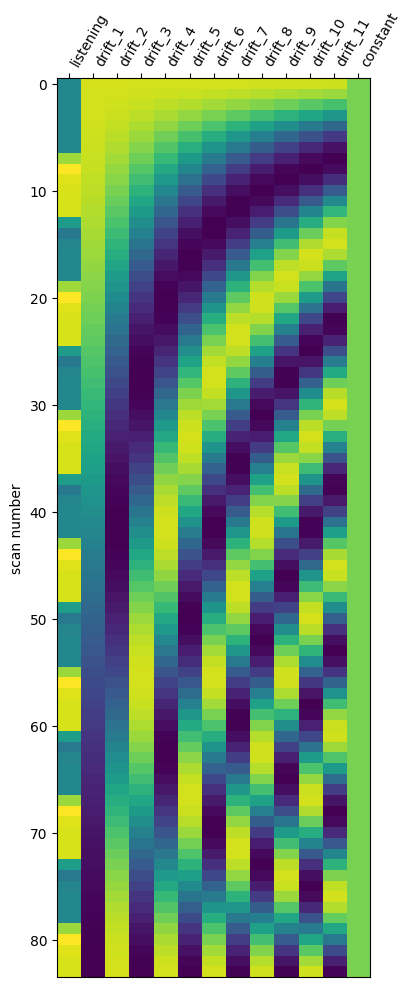

In [10]:
from nilearn.plotting import plot_design_matrix

# plot the design matrix
plot_design_matrix(design_matrix)

### Save the Design Matrix to Disc

In [11]:
# save design matrix to disc
plot_design_matrix(design_matrix, output_file='design_matrix.png')

### Plot the Expected Response

The first column of the design matrix contains the expected response profile of regions which are sensitive to the auditory stimulation.

We plot this first column:

Text(0.5, 1.0, 'Expected Auditory Response')

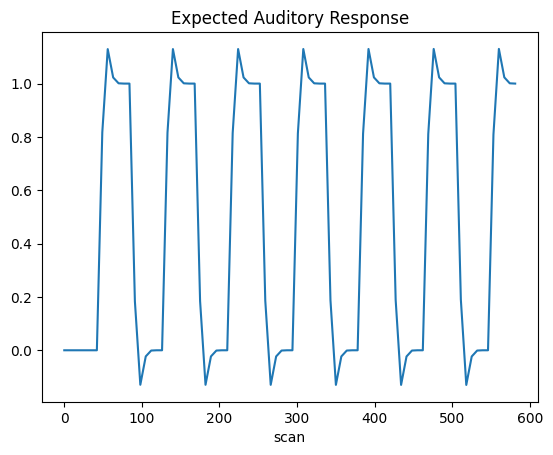

In [12]:
# plot the first column of the design matrix
plt.plot(design_matrix["listening"])

plt.xlabel("scan")
plt.title("Expected Auditory Response")

## Detecting Voxels With Significant Effects

### Computing Contrast

To get more interesting results out of the GLM model, contrasts can be computed between regressors of interest.

A contrast is a weighted combination of the estimated effects.

Its role is to select some columns of the model –and potentially weight them– to study the associated statistics.

First, the contrasts of interest must be defined.

We define a contrast of interest that just considers the effect of the stimulation in isolation.

Here the baseline is implicit, so passing a value of **`1`** for the first column will give contrast for: **`listening > rest`**.

In [13]:
# create contrast
n_regressors = design_matrix.shape[1]
activation = np.zeros(n_regressors)
activation[0] = 1

We plot the coefficients of the contrast, indexed by the names of the columns of the design matrix.

The Nilearn **`plot_contrast_matrix`** function is a utility used to visualize contrast definitions in the context of General Linear Models.

It specifically helps verify that your contrast vectors or matrices correctly target the intended regressors in your design matrix

<Axes: label='conditions'>

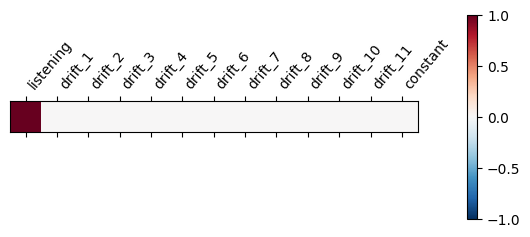

In [14]:
from nilearn.plotting import plot_contrast_matrix

# plot contrast matrix
plot_contrast_matrix(contrast_def=activation, design_matrix=design_matrix)

### Parameter Estimate

Effect sizes quantify the magnitude of the BOLD signal change in response to a task, representing the strength of neuronal activity rather than just statistical significance.

They are typically calculated as a parameter estimate ($\beta$ values).

The $\beta$ values represent the estimated change in BOLD signal for each regressor (task condition).

The contrast comparing rows in the design matrix results in a parameter estimate that signifies how well the underlying model fits the data at each voxel.

For statistical inferences the parameter estimate is commonly converted to either a t-statistic, or z-statistic.

In Nilearn the parameter estimate is referred to as **`effect_size`**.

The Nilearn **`fmri_glm.compute_contrast`** is a core function used to evaluate specific hypotheses about brain activity after fitting a General Linear Model.

It compares the estimated coefficients ($\beta$ values) for different conditions to produce statistical maps, such as **z-scores** or **t-statistics**.

The function parameter **`output_type`** determines what the function returns and sets the type of statistical map. Common options include:
* **`'z_score'`**: Standardized map of statistical significance.
* **`'stat'`**: The raw t or F statistic.
* **`'effect_size'`**: The $\beta$ weights/parameter estimates of the contrast.


In [15]:
# create effect size map
eff_map = fmri_glm.compute_contrast(activation, output_type="effect_size")

[FirstLevelModel.compute_contrast] Computing image from signals

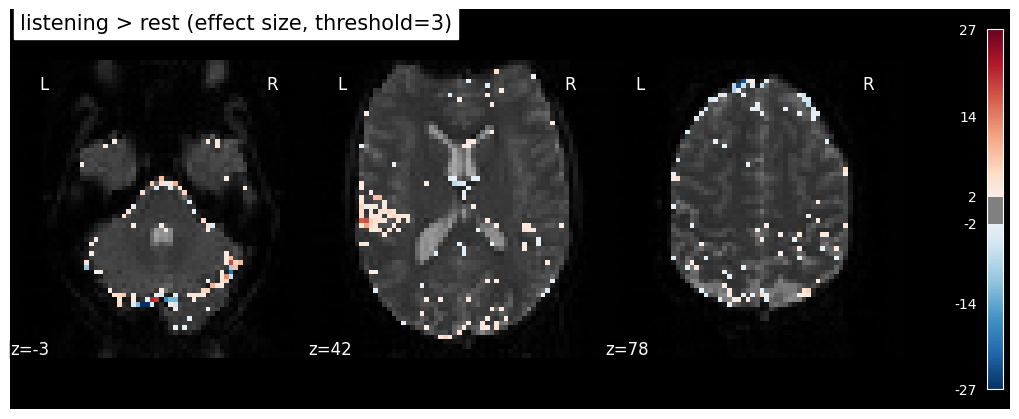

In [40]:
# configure plotting
plotting_config = {
    "bg_img": mean_img,
    "display_mode": "z",
    "cut_coords": 3,
    "black_bg": True,
}

# plot effectice size map
plot_stat_map(
    eff_map,
    threshold=2,
    title="listening > rest (effect size, threshold=3)",
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)

### z-Map

The computed estimated effect is in BOLD signal unit, but has no statistical guarantees, because it does not take into account the associated variance.

In order to get statistical significance, we form a t-statistic, and directly convert it into z-scale.

The z-scale means that the values are scaled to match a standard Gaussian distribution (mean=0, variance=1), across voxels, if there were no effects in the data.

In [17]:
# create a z-map
z_map = fmri_glm.compute_contrast(activation, output_type="z_score")

[FirstLevelModel.compute_contrast] Computing image from signals

## Plot Thresholded z-Score Map

We display the thresholded z-score map on top of the average functional image of the series (could be the anatomical image of the subject).

We use arbitrarily a threshold of 3.0 in z-scale.

We show 3 axial views, with **`display_mode='z'`** and **`cut_coords=3`**.

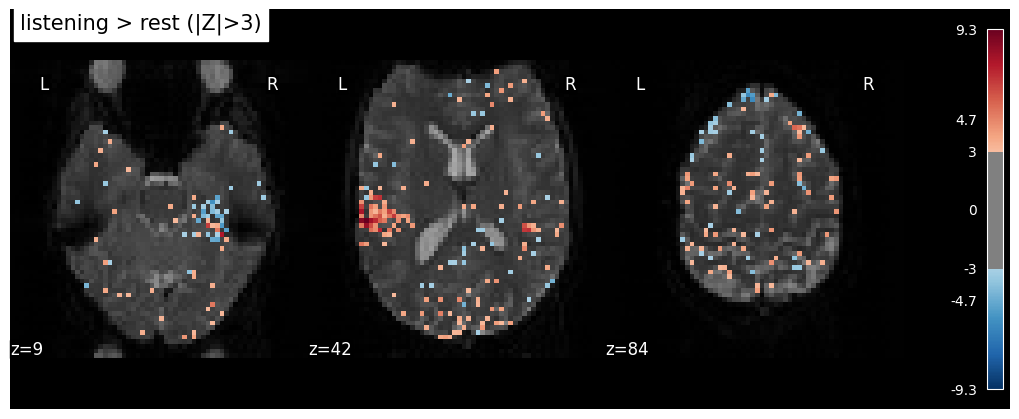

In [18]:
# configure plotting
plotting_config = {
    "bg_img": mean_img,
    "display_mode": "z",
    "cut_coords": 3,
    "black_bg": True,
}

# plot z-map
plot_stat_map(
    z_map,
    threshold=3,
    title="listening > rest (|Z|>3)",
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)

Notice how the visualizations above shows both "activated" voxels with Z > 3, as well as "deactivated" voxels with Z < -3.

In the rest of this example we will show only the activate voxels by using one-sided tests.

## Statistical Significance Testing

A Type I error, or "false positive," occurs in statistics when the null hypothesis $(H_{0})$ is true, but is incorrectly rejected.

This means concluding that a statistically significant effect or difference exists in the population when it actually does not.

It represents a "false alarm" where random chance is misinterpreted as a real, significant result.

In our example, we used an arbitrary threshold of 3.0, but the threshold should provide some guarantees on the risk of false positive (Type I error), which raises questions about the statistical validity of the procedure.

One suggestion is to control the false positive rate (fpr, denoted by alpha) at a certain level, e.g. 0.001: this means that there is 0.1% chance of declaring an inactive voxel as active.

False positive rate correction refers to the methods employed to correct false positive rates such as the Bonferroni correction which divides the significance level by the number of comparisons made.

### Treshold Statistical Maps

The Nilearn **`threshold_stats_img`** is a powerful tool used to threshold statistical maps (typically z-scale images) by applying specific alpha values and multiple comparison corrections.

It translates a desired significance level into a z-scale threshold to produce a mask of significant voxels.

**Key Parameters**

* **`stat_img`**: The input statistical image (Niimg-like) to be thresholded, usually in z-scale.
* **`alpha`**: The significance level (e.g., 0.05 or 0.001) used to control the threshold.
* **`height_control`**: Defines the type of multiple comparisons correction:
    * **`'fpr'`**: False Positive Rate (uncorrected). This is lenient and may result in many false positives.
    * **`'fdr'`**: False Discovery Rate (Benjamini-Hochberg). This controls the proportion of false positives among detections and is commonly advised for reporting results.
    * **`'bonferroni'`**: Family-Wise Error Rate (FWER) correction. This is the most conservative method, significantly reducing false positives but potentially increasing false negatives.
    * **`None`**: Uses a raw z-threshold instead of a p-value.
* **`cluster_threshold`**: Minimum cluster size (in voxels) required for a cluster to be retained in the output.

In the **`height_control`** parameter, **`'fdr'`** is used for more stringent, publication-ready results, while **`'fpr'`** might be used for exploratory purposes.

### Plotting Threshold z-Maps

**Uncorrected**

Plot z-map with **`height_control`** parameter set to **`fpr`** (uncorrected):

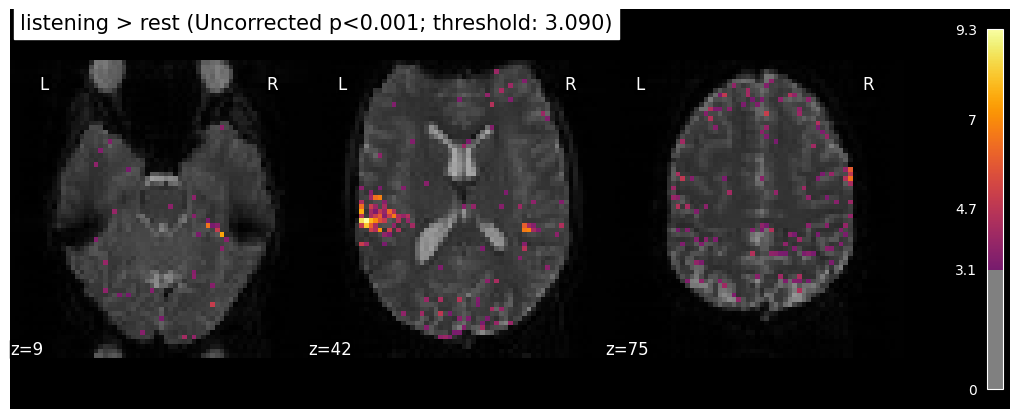

In [19]:
from nilearn.glm import threshold_stats_img

clean_map, threshold = threshold_stats_img(
    z_map,
    alpha=0.001,
    height_control="fpr",
    two_sided=False,  # using a one-sided test
)

# use a sequential colormap as we will only display positive values.
plotting_config["cmap"] = "inferno"
plot_stat_map(
    clean_map,
    threshold=threshold,
    title=(
        f"listening > rest (Uncorrected p<0.001; threshold: {threshold:.3f})"
    ),
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)

**Bonferroni correction**

Bonferroni correction is a more conservative solution that controls the family wise error rate, i.e. the probability of making only one false detection, say at 5%.

Plot z-map with **`height_control`** parameter set to **`bonferroni`**.

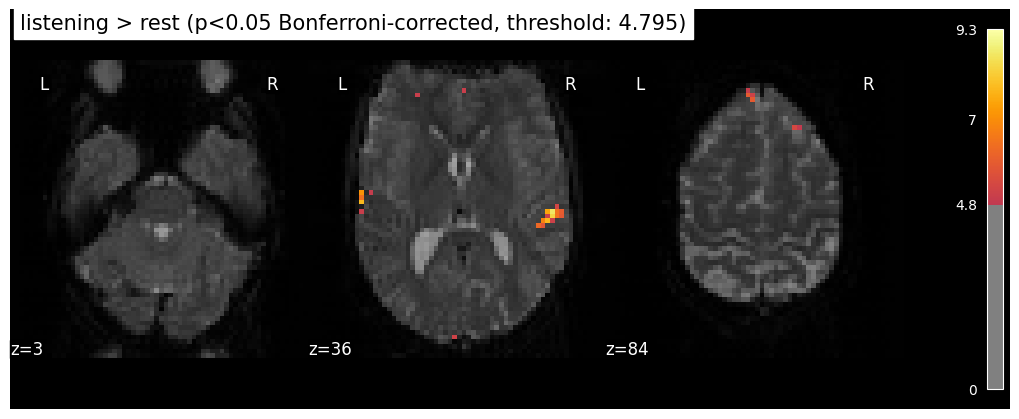

In [36]:
clean_map, threshold = threshold_stats_img(
    z_map,
    alpha=0.05,
    height_control="bonferroni",
    two_sided=False
)

plot_stat_map(
    clean_map,
    threshold=threshold,
    title=(
        "listening > rest (p<0.05 Bonferroni-corrected, "
        f"threshold: {threshold:.3f})"
    ),
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)

**False Discovery Rate Correction**

FDR correction controls the expected proportion of false discoveries among detections.

Plot z-map with **`height_control`** parameter set to **`fdr`**.

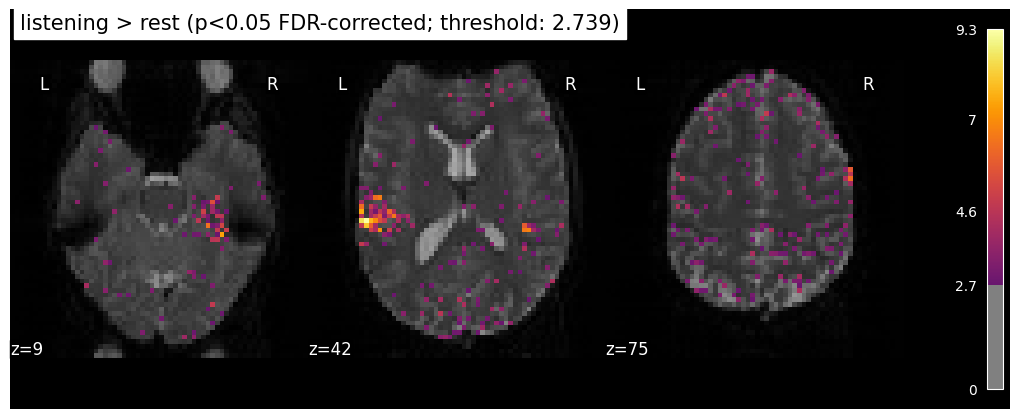

In [37]:
clean_map, threshold = threshold_stats_img(
    z_map,
    alpha=0.05,
    height_control="fdr",
    two_sided=False
)

plot_stat_map(
    clean_map,
    threshold=threshold,
    title=(
        f"listening > rest (p<0.05 FDR-corrected; threshold: {threshold:.3f})"
    ),
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)

**Cluster Treshold**

Cluster treshold allow to discard isolated voxels ("small clusters") from these images.

It is possible to generate a thresholded map with small clusters removed by setting a **`cluster_threshold`** argument.

Here clusters smaller than 10 voxels will be discarded.

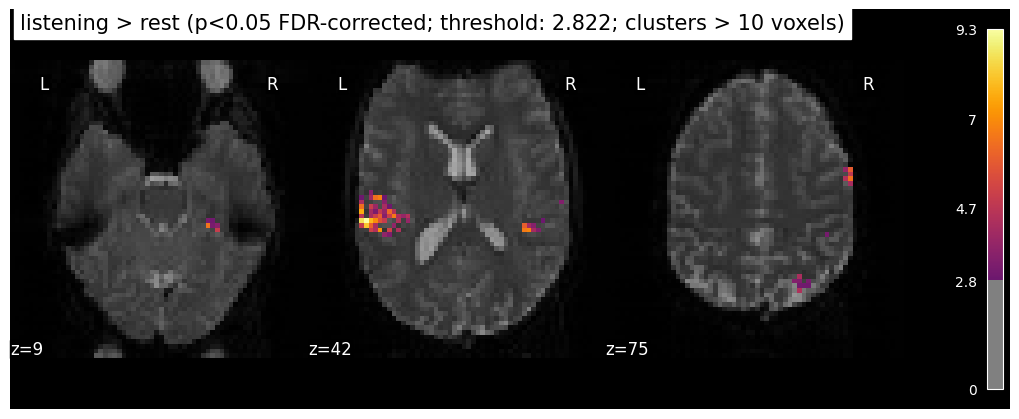

In [22]:
clean_map, threshold = threshold_stats_img(
    z_map,
    alpha=0.05,
    height_control="fdr",
    cluster_threshold=10,
    two_sided=False,
)

plot_stat_map(
    clean_map,
    threshold=threshold,
    title=(
        "listening > rest "
        f"(p<0.05 FDR-corrected; threshold: {threshold:.3f}; "
        "clusters > 10 voxels)"
    ),
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)

**Save z-map**

We save the effect and z-score maps to the disk:

In [23]:
z_map.to_filename('listening_gt_rest_z_map.nii.gz')
eff_map.to_filename('listening_gt_rest_eff_map.nii.gz')

**Extract report**

We extract and report the found positions in a table:

In [24]:
from nilearn.reporting import get_clusters_table

table = get_clusters_table(z_map, stat_threshold=threshold, cluster_threshold=20)

table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-60.0,-6.0,42.0,9.341729,3888
1,1a,-51.0,-12.0,39.0,7.952826,
2,1b,-63.0,0.0,42.0,7.595170,
3,1c,-42.0,-12.0,39.0,7.034967,
4,2,60.0,0.0,36.0,8.738699,1620
5,2a,45.0,-12.0,42.0,6.850138,
6,2b,69.0,6.0,30.0,4.062676,
7,3,66.0,15.0,27.0,7.947193,837
8,3a,51.0,3.0,30.0,6.676518,
9,4,36.0,-3.0,15.0,7.945328,1161


## Performing an F-test

**`listening > rest`** is a typical t-test: condition versus baseline.

Another popular type of test is an F-test, in which one seeks whether a certain combination of conditions (possibly two-, three- or higher-dimensional) explains a significant proportion of the signal.

Here one might for instance test which voxels are well explained by the combination of more active or less active than rest.

As opposed to a t-test, the beta images produced by an F-tests only contain positive values.

We specify the contrast and compute the corresponding map.

Actually, the contrast specification is done exactly the same way as for t-contrasts.

In [25]:
z_map = fmri_glm.compute_contrast(
    activation,
    output_type="z_score",
    stat_type="F",  # set stat_type to 'F' to perform an F-test
)

[FirstLevelModel.compute_contrast] Computing image from signals

Note that the statistic has been converted to a z-score, which makes it easier to represent it.

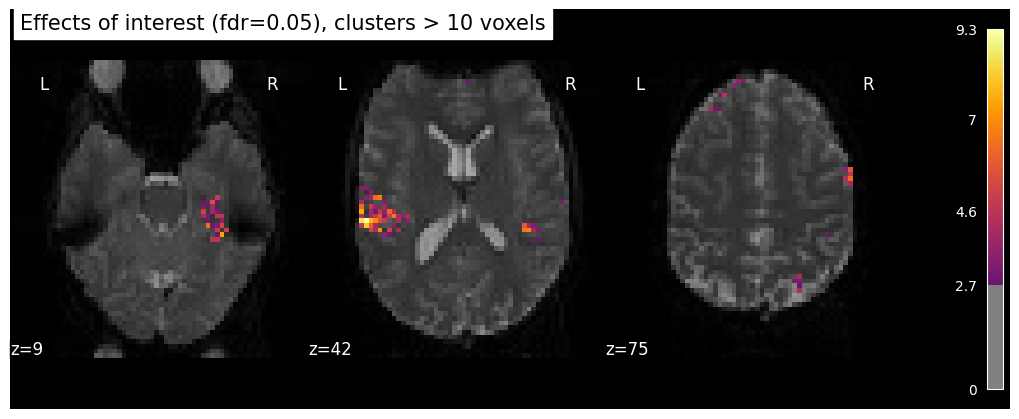

In [26]:
clean_map, threshold = threshold_stats_img(
    z_map,
    alpha=0.05,
    height_control="fdr",
    cluster_threshold=10,
    two_sided=False,
)

plot_stat_map(
    clean_map,
    threshold=threshold,
    title="Effects of interest (fdr=0.05), clusters > 10 voxels",
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)

## Predicted Time Series

We extract the predicted time series to assess the quality of the model fit.

### Extract the Largest Cluster

We extract the coordinates of the largest cluster from the clusters table we generated previously. This cluster is in the top row of the table.

To use this coorinates in a masker the coordinates variable must be a list of triplets:

In [27]:
# Extract the largest cluster
largest_cluster = table.iloc[0]
coords = [(largest_cluster['X'], largest_cluster['Y'], largest_cluster['Z'])]

### Define a Masker

The **`NiftiSpheresMasker`** is a specialized tool in Nilearn used to extract brain signals from spherical regions of interest (ROIs) centered around specific seed coordinates.

A Masker converts 4D fMRI image data into a 2D array of time series (voxels by time points).

The typical workflow involves three main steps:

1. **Initialization:** Define your seeds (coordinates) and the radius of the spheres.
2. **Fitting:** "Fit" the masker to your data (this validates the coordinates against the image affine).
3. **Transforming:** Extract the time series from your 4D functional images.

We initialize a masker with the coordinates of the largest cluster.

We set the parameter **`standardize='zscore_sample'`** to standardize fMRI images (rescale to zero mean and unit variance).

In [28]:
from nilearn.maskers import NiftiSpheresMasker

# Define a mask from coordinates to inspect
masker = NiftiSpheresMasker(coords, standardize="zscore_sample", radius=4)

### Extract Signals

A Masker converts 4D fMRI image data into a 2D array of time series (voxels by time points).

We extract the observed and the predicted times series.

In [30]:
# Extract observed and predicted time series
observed_timeseries = masker.fit_transform(fmri_img[0])
predicted_timeseries = masker.fit_transform(fmri_glm.predicted[0])


[FirstLevelModel.predicted] Computing image from signals

### Plot the Time Series

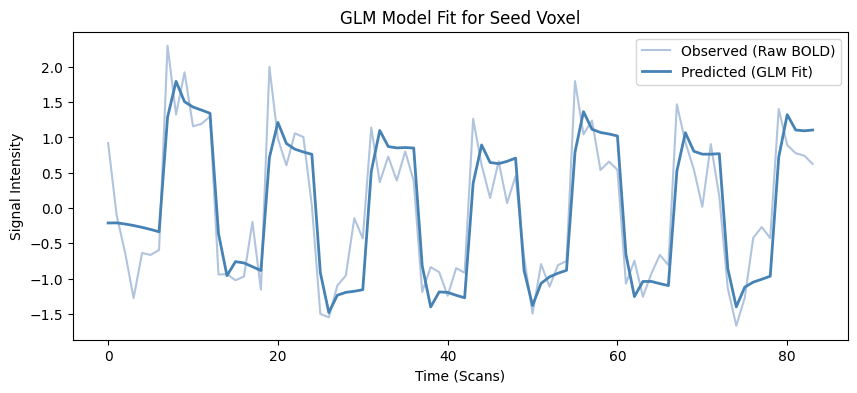

In [31]:
plt.figure(figsize=(10, 4))
plt.plot(observed_timeseries, label='Observed (Raw BOLD)', color='lightsteelblue')
plt.plot(predicted_timeseries, label='Predicted (GLM Fit)', color='steelblue', linewidth=2)
plt.xlabel('Time (Scans)')
plt.ylabel('Signal Intensity')
plt.legend()
plt.title('GLM Model Fit for Seed Voxel')
plt.show()